### Nome: Samuel Felipe dos Santos

# PROJET0 3 - GNG

Relatório realizado para disciplina de Redes Neurais, contendo experimentos realizados com a rede GNG. O relatório foi desenvolvido fazendo uso da ferramenta Jupyter Notebook, e pode ser melhor visualizado em <a href="https://github.com/felipe-samuel/NeuralNetworksProjects/blob/master/project_03-gng_experiments.ipynb">https://github.com/felipe-samuel/NeuralNetworksProjects/blob/master/project_03-gng_experiments.ipynb</a>


<UL>
<LI>Experimentos da rede GNG com pelo menos 3 datasets;
<LI>Variar:
<UL>
<LI>Idade links;
<LI>Tempo para adição de neurônios;
<LI>Número de neurônios.

## Metodologia

Nessa seção será descrita a metodologia experimental utilizada nesse trabalho, que teve como objetivo realizar experimentos com a rede GNG. 

Foram realizados experimentos variando idade máxima que as arestas podem atingir antes de serem removidas (se não forem renovadas), a quantidades de iterações da rede após a qual é adicionado um novo neurônio e a quantidade máxima de neurônios que podem ser adicionados na rede. Para escolher a melhor configuração da rede foram utilizados o erro quantitativo e o erro topográfico (adaptados da rede SOM implementada no projeto 2).

Para avaliar o que está sendo aprendido pela rede foram gerados os gráficos Hit map, Heat maps e U-matrix para o melhor modelo encontrado, novamente adptando a implmentação do projeto 2 para funcionar com grafos.

O Heat map e Hit map foram gerados para cada classe dos datasets de forma separada, sendo possivel dessa forma verificar como os exemplos de cada uma dessas classes se comportam na representação dos dados gerada pela GNG.


### Bibliotecas utilizadas

Foi utilizada a linguagem de programação Python 3.0 em conjunto com as bibliotecas:
<UL>
    <LI> <b>Sklearn:</b> Possui rotinas de aprendizados de máquina;
    <LI> <b>Pandas:</b> Utilizada para criar e salvar as tabelas com os dados obtidos nos experimentos;
    <LI> <b>Neupy:</b> Uma biblioteca que possue implementações de redes neurais feitas sobre tensorflow;
    <LI> <b>Networkx e Mathplotlib:</b> Possuem rotinas de criação de grafos. 
</UL>

In [ ]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from neupy.algorithms import GrowingNeuralGas
import networkx as nx

### Rede GNG Usada

Foi utilizada a implementação da <a href="http://neupy.com/apidocs/neupy.algorithms.competitive.growing_neural_gas.html">rede GNG presente na biblioteca Neupy</a>. 

Essa implementação tem como alguns dos seus principais parâmetors:
<UL>
    <LI> <b>n_inputs:</b> Dimensões dos de um exemplo da entrada;
    <LI> <b>n_start_node:</b> Número de neurônios com o qual a rede é inicializada, sendo por padrão 2;
    <LI> <b>step:</b> Taxa de aprendizado para o neurônio vencedor (BMU), 0.2 por padrão;
    <LI> <b>neighbour_step:</b> Taxa de aprendizado para os vizinhos do neurônio vencedor, 0.05 por padrão;
    <LI> <b>error_decay_rate:</b> Decaimento aplicado a todos neurônios após cada iteração da rede, padrão=0.995;
    <LI> <b>after_split_error_decay_rate:</b> Decaimento aplicado aos neurônios com o maior erro após a adição de um novo neurônio na rede, padrão=0.5;
    <LI> <b>max_edge_age:</b> Número de iterações máximo que uma aresta pode passar sem ser atualizada antes de ser removida, padrão=1000;
    <LI> <b>n_iter_before_neuron_added:</b> Número de iterações até que um novo neurônio seja adicionado, padrão=1000;
    <LI> <b>max_nodes:</b> Número máximo de nós que podem ser adicionado durante o treinamento. padrão=1000.
</UL>

Segue no código abaixo um pequeno exemplo da utilização dessa rede.

In [3]:
neural_gas = GrowingNeuralGas(n_inputs=4,
                              shuffle_data=True,
                              max_edge_age=10,
                              n_iter_before_neuron_added=50,
                              max_nodes=100)

data = np.array([[1,1,0,0],[0,0,0,1],[1,0,0,0],[0,0,1,1]])
neural_gas.fit( data, 100 )

GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=4, n_start_nodes=2, neighbour_step=0.05, max_edge_age=10, max_nodes=100, n_iter_before_neuron_added=50, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0.0)

Abaixo é mostrada as implementações de funções utilizadas para desenhar grafos com o nós e arestas criados pela rede GNG. 

- A função <i>decode_edges</i>  converte o formato da lista de arestas de <i>(pesos do nó 1, pesos do nó 2)</i> para <i>(identificador do nó 1, identificador do nó 2)</i>; 
- A função <i>adjacency_matrix</i> cria uma matrix de adjacência por meio das arestas e nós do grafo gerado pela GNG;
- A função <i>generate_graph</i> cria um grafo no formato da bibliotéca <i>networkx</i> tendo como entrada uma matriz de adjacências;
- A função <i>print_graph</i> realiza a impresão do grafo utilizando a bibliotéca <i>networkx</i>, representando as a intensidade dos nós por meio de cores (do azul para o mais baixo até o verde sendo o mais alto) e pela variação do tamanho. 

In [4]:
def decode_edges(graph):
    nodes = list(graph.nodes)
    edges = list(graph.edges.keys())
    edges_decoded = []
    for i in range(len(edges)):
        edge = [-1,-1]
        for j in range(len(nodes)):
            if edges[i][0] == nodes[j]:
                edge[0] = j
            if edges[i][1] == nodes[j]:
                edge[1] = j
        edges_decoded += [ edge ]
    return edges_decoded

def adjacency_matrix(edges, n_nodes):
    adj = np.zeros([n_nodes,n_nodes])
    for edge in edges:
        adj[edge[0], edge[1]] += 1
    return adj

def generate_graph(m):
    g = nx.from_numpy_matrix( m )
    pos = nx.spring_layout(g)
    return g, pos

def print_graph(g, pos, labels=True, values=None, base=100, multiplier=10, font_size=10, color_map = 'cool'):
    if not(values is None):
        values_map = {}
        for i in range(len(values)):
            values_map[i] = values[i]
        values *= multiplier
        values += base
        nx.draw(g, pos=pos, cmap=plt.get_cmap(color_map), node_color=values, labels =values_map, font_size=font_size, font_color='white', node_size=values)
    else:
        nx.draw(g,with_labels=labels, font_weight='bold')    

As funções a seguir foram adaptadas da projeto 2 da rede SOM, para possibilitara o cálculo da erro de quantização e erro topológico sobre a rede GNG.

In [5]:
def distance(p, q):
    return sqrt(np.sum((p-q)**2))

def are_neighbors(edges, p, q):
    for (i,j) in edges:
        if (p == i and q == j) or (q == i and p == j):
            return True
    return False

def discriminant_function(nodes, input_sample):
    discriminant = np.zeros(len(nodes))
    for i in range(len(nodes)):
        discriminant[i] = np.sum(np.power(nodes[i].weight - input_sample, 2))
    return discriminant

def competitive_phase(nodes, input_sample):
    discriminant = discriminant_function( nodes, input_sample )
    BMU = np.unravel_index(discriminant.argmin(), discriminant.shape)
    return discriminant, np.array(BMU)

def quantization_error( graph, data):
    error = 0.0
    for i in range(len(data)):
        input_sample = data[i]
        BMU = competitive_phase(graph.nodes, input_sample)[1][0]
        error+= distance( graph.nodes[BMU].weight, input_sample)
    error /= len(data)
    return error

def topographical_error(graph, data):
    error = 0.0
    for i in range(len(data)):
        input_sample = data[i]
        discriminant, BMU = competitive_phase(graph.nodes, input_sample)
        BMU = BMU[0]
        discriminant[BMU] = len(graph.nodes)
        BMU2 = np.unravel_index(discriminant.argmin(), discriminant.shape)[0]
        edges = decode_edges(graph)
        if not are_neighbors(edges, BMU, BMU2):
            error += 1.0
    error /= len(data)
    return error

Abaixo é calculado o erro quantitativo e topográfico para o exemplo apresentado anteriormente.

In [6]:
qe = quantization_error(neural_gas.graph, data)
te = topographical_error(neural_gas.graph, data)
print('quantization error =', qe)
print('topographical error =', te)

quantization error = 2.0231968214719536e-05
topographical error = 0.0


Foram adaptadas também as implementados de métodos para gerar as matrizes que podem ser usadas para gerar os seguintes gráficos:
<UL>
<LI> <b> U-matrix</b>
<LI> <b> HeatMap</b>
<LI> <b> HitMap</b>
</UL>

In [7]:
def u_matrix(nodes, edges):
    um = np.zeros(len(nodes))
    for i in range( len(nodes) ):
        for j in range( len(nodes) ):
            if are_neighbors(edges, i, j):
                um[i] += distance(nodes[i].weight, nodes[j].weight)
    return um

In [8]:
def heatmap(nodes, sample): 
    hem = np.zeros(len(nodes))
    for i in range(len(nodes)):
        hem[i] = distance(nodes[i].weight, sample)
    return hem

In [9]:
def hitmap(nodes, edges, data):
    hm = np.zeros(len(nodes))    
    for i in range(len(data)):
        BMU = competitive_phase(nodes, data[i])[1][0]
        hm[BMU] += 1.0
    return hm

Abaixo é gerado a U-matrix, Heat map e Hit map para o exemplo mostrado anteriormente.

In [11]:
um  = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph))
hem = heatmap(neural_gas.graph.nodes, data[0]) 
hm  = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), data )
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )
print('u-matrix:',um)
print('heatmap:', hem)
print('hitmap:', hm)

u-matrix: [0.01032098 0.06986356 0.03764093 0.07008134 0.96011532 0.95235971
 0.85996893 0.85975115 0.0402063  0.14016267]
heatmap: [3.20980835e-07 1.99998209e+00 9.99999764e-01 1.73205074e+00
 9.62536109e-01 4.02066027e-02 1.73771616e+00 1.96598211e+00
 1.03212814e-02 1.73346970e+00]
hitmap: [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


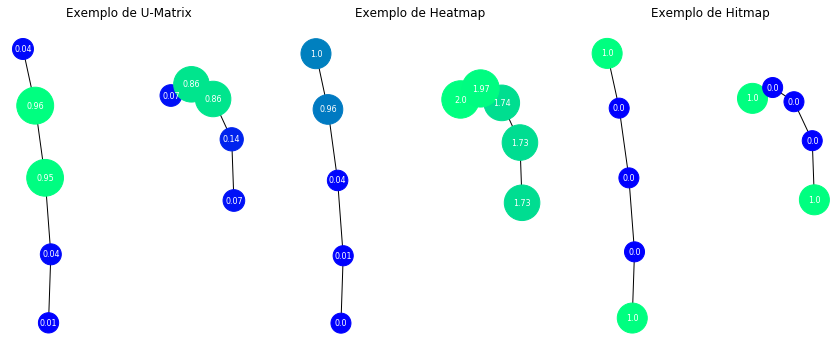

In [12]:
plt.figure(figsize=(20, 6))

plt.subplot(141)
plt.title('Exemplo de U-Matrix')
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=400, multiplier=1000, font_size=8, color_map = 'winter')

plt.subplot(142)
plt.title('Exemplo de Heatmap')
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=400, multiplier=500, font_size=8, color_map='winter')

plt.subplot(143)
plt.title('Exemplo de Hitmap')
print_graph(g, pos, labels=True, values=hm,                    base=400, multiplier=500, font_size=8, color_map = 'winter')

### Datasets
Foram escolhidos os seguintes três datasets para avaliação dos resultados:
<UL>
<LI><b>Iris Dataset:</b> consiste de 50 amostras  de cada uma das 3 espécies da flor iris, que está disponivel no pacote Sklearn;

<LI><b>Breast Cancer Wisconsin (Diagnostic) Dataset:</b> características computadas a partir de imagens biomédicas, e utilizadas para classificar se há câncer de mama, mais detalhes podem ser encontrados em 
<a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)</a>. Foi utilizada a versão disponibilizada no pacote Sklearn;

<LI><b>Alcohol QCM Sensor Dataset Dataset:</b> consiste de amostras de álcool que podem ser classificadas em 5 tipos (1-octanol, 1-propanol, 2-butanol, 2-propanol, 1-isobutanol). Os atributos de cada amostra consistem de medições realizadas por sensores com diferentes configurações, que atribuidas sobre a amostra no formato de gás em diferentes concentrações. Foi utilizado a versão do dataset disponível em <a href="https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset">https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset</a>, onde se encontram mais detalhes.
</UL>


### Pré-processamento dos dados

Os dados então são normalizados utilizando a função <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> da biblioteca Sklearn, que realiza a seguinte operação:<br />
<br />
z = (x - u) / s<br />
<br />
Onde x é uma amostra, u é a média das amostras do treino e s o desvio padrão do treino.


In [10]:
def Normalize( X ):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

### Otimização dos Hiperparâmetros da Rede

Foram realizados experimentos variando os hiperparâmetros de idade máxima de uma aresta, número de iterações para a adição de um novo neurônio e o número máximo de neurônios que podem ser adicionados na rede, testando os valores mostrados no código abaixo, sendo os utilizados os valores padrão para os demais hiperparâmetros da rede. 

In [11]:
parameters = {
    'max_edge_age': [25, 50, 75,   100],
    'n_iter_before_neuron_added': [25,  50   , 75, 100  ],
    'max_nodes': [25, 50, 75, 100]
}

A busca pelos hiperparâmetros ideais foi realizada pela função <b>grid_serach</b> implementada a seguir. Ela realiza uma busca exaustiva sobre um dicionário de hiperparâmetros. Cada combinação de hiperparâmetros é utilizada para treinar a rede 3 vezes, obtendo um erro de quantização médio, erro de topográfico médio e o desvio padrão de ambos para cada combinação de hiperparâmetros.

In [12]:
def grid_search(parameters, data, repetitions=3, epochs=100):
    results = {
        'max_edge_age': [],
        'n_iter_before_neuron_added': [],
        'max_nodes': [],
        'quantization_error': [],
        'topographical_error': [],
        'quantization_error_std': [],
        'topographical_error_std': []
    }
    total = len(parameters['max_edge_age']) * len(parameters['n_iter_before_neuron_added']) * len(parameters['max_nodes']) * repetitions
    i=1
    for age in parameters['max_edge_age']:
        for n_iter in parameters['n_iter_before_neuron_added']:
            for m_nodes in parameters['max_nodes']:
                qe = []
                te = []
                for r in range(repetitions):
                    print(i, 'of', total, ':' , len(data[0]),age, n_iter, m_nodes, r )
                    
                    ng = GrowingNeuralGas(n_inputs=len(data[0]),
                              shuffle_data=True,
                              verbose=True,
                              max_edge_age=age,
                              n_iter_before_neuron_added=n_iter,
                              max_nodes=m_nodes)
                    ng.fit(data, epochs)
                    
                    q = quantization_error(ng.graph, data)
                    t = topographical_error(ng.graph, data)                            
                    print(q, t)
                    qe += [q]
                    te += [t]
                    i+=1
                qe_mean = np.mean(qe)
                qe_std = np.std(qe)
                te_mean = np.mean(te)
                te_std = np.std(te)
                results['max_edge_age'] += [age]    
                results['n_iter_before_neuron_added'] += [n_iter]
                results['max_nodes'] += [m_nodes]

                results['quantization_error'] += [qe_mean]
                results['topographical_error'] += [te_mean]
                results['quantization_error_std'] += [qe_std]
                results['topographical_error_std'] += [te_std]      
    return results

### Avaliação dos Resultados

Após a realização do grid search, são analisados os impactos dos hiperparâmetros escolhidos, sendo definido como melhor modelo o que obter o menor erro quantitativo, tendo como desempate o erro topográfico.

Para esse modelo, são gerados heatmaps, hitmap e u-matrix com o objetivo de tentar entender como o grafo gerado pela GNG está representando os dados dos exemplos de cada classe dos datasets.

## Resultados

### Dataset 1: Iris

In [13]:
def loadIris():
    iris = load_iris()
    return iris.data, iris.target
iris_X, iris_Y = loadIris()

In [14]:
iris_X = Normalize(iris_X)

In [ ]:
results = grid_search(parameters, iris_X)

In [52]:
Iris_results =pd.DataFrame.from_dict(results)
export_csv = Iris_results.to_csv(r'results/GNG/Iris_grid_search.csv', index = None, header=True)

Abaixo é mostrado os 10 melhores resultados obtidos no grid search, podendo ser observado que foram obtidos resultados erro de quantização e erro topográfico baixos. No caso do erro topográfico, foi obtido erro=0 para diversas configurações da rede, sendo um dos possíveis motivos a grande quantidade de neurônios da rede, sendo os pesos desses próximos (mais próximos quando estão conectados por arestas).

Em relação a idade máxima da aresta, a rede apresentou um desempenho melhor para valores mais baixos sendo o melhor resultado obtido com a remoção da aresta após 25 iterações sem atualização. 
Para a adição de neurônios, todos os valores testados foram observados, no entanto, novamente a rede aparenta favorecer valores mais baixos sendo o melhor resultado obtido com os neurônios sendo adicionados após 25 iterações.
Para o número máximo de neurônios todos os melhores resultados foram obtidos com 100 neurônios, a maior quantidade testada.

In [8]:
Iris_results_table = pd.read_csv('results/GNG/Iris_grid_search_sample.csv')
Iris_results_table

,max_edge_age,n_iter_before_neuron_added,max_nodes,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,25,25,100,0.137524,0.000000,0.000766,0.000000
1,25,50,100,0.137957,0.000000,0.001129,0.000000
2,25,100,100,0.138088,0.000000,0.003354,0.000000
3,50,25,100,0.138470,0.000000,0.001786,0.000000
4,25,75,100,0.140045,0.000000,0.001876,0.000000
5,50,50,100,0.142529,0.000000,0.001686,0.000000
6,75,25,100,0.144572,0.000000,0.004006,0.000000
7,50,100,100,0.145341,0.002222,0.001649,0.003143
8,75,75,100,0.145503,0.002222,0.001719,0.003143
9,50,75,100,0.145600,0.000000,0.000677,0.000000


Abaixo é mostrada a configuração da rede que foi considerada a melhor por possuir o menor erro quantitativo, e com a qual serão realizados os próximos experimentos.

In [9]:
Iris_results_table.loc[[0]]

,max_edge_age,n_iter_before_neuron_added,max_nodes,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,25,25,100,0.137524,0.0,0.000766,0.0


A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que foi obtido um resultado baixo em ambos.

In [ ]:
neural_gas = GrowingNeuralGas(n_inputs=len(iris_X[0]),
                              shuffle_data=True,
                              verbose=True,
                              max_edge_age=25,
                              n_iter_before_neuron_added=25,
                              max_nodes=100)
neural_gas.fit( iris_X, 100 )

In [16]:
print('Erro de quantização =', quantization_error(neural_gas.graph, iris_X))
print('Erro Topografico =', topographical_error(neural_gas.graph, iris_X))
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )

Erro de quantização = 0.14045376948526622
Erro Topografico = 0.0


A seguir é apresentado o Heat Map para três exemplos de cada classe, que mostra a distância dos pesos de um exemplo em relação aos pesos dos neurônios da rede. 

Pode ser observado os exemplos da classe setosa apresentarão uma distância menor para alguns neurônios na parte superior e maior para os neurônios no centro. No entanto, as classes Versicolour e Virginica se mostrarm similares, obtendo distâncias similares para o grupo de neurônios no centro.

Possíveis razões para esse ocorrido são a similaridade entre essas duas classes e/ou uma similaridade entre os pesos dos neurônios devido a grande quantidade deles.

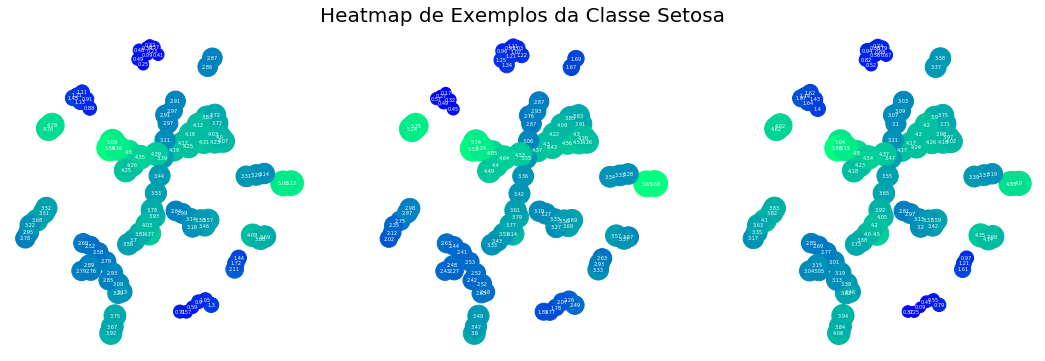

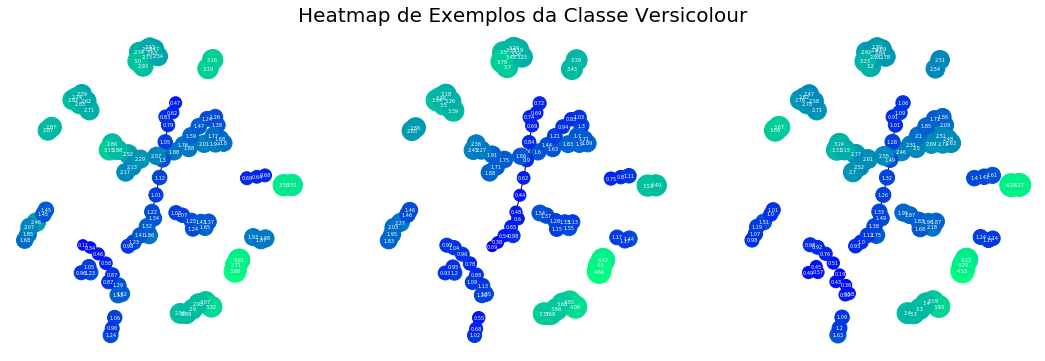

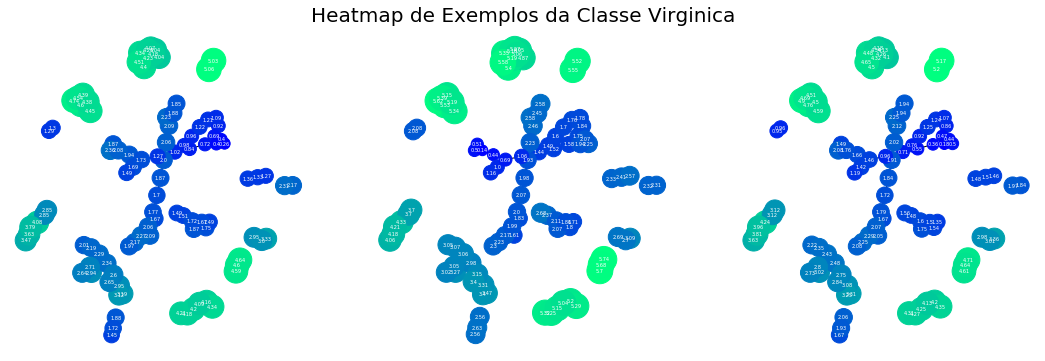

In [17]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, iris_X[0]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Setosa',      fontsize=20)
hem = heatmap(neural_gas.graph.nodes, iris_X[12]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, iris_X[48]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, iris_X[66]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Versicolour', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, iris_X[83]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, iris_X[90]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, iris_X[100]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Virginica', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, iris_X[122]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, iris_X[144]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

O Hit Map mostra a quantidade de exemplos que tiveram cada neurônio como o seu BMU (Best Matching Unit, neurônio com a menor distância entre seus pesos e um exemplo). 

Apesar dos resultados observados nos heat maps, não houve exemplos de classes diferentes que tiveram o mesmo neurônio como BMU, o que mostra que os exemplos de classes diferentes estão sendo mapeados para regiões diferentes do mapa. Pode ser observado também que houve uma grande quantidade de neurônios que não foram escolhidos como (BMU) por nenhum exemplo do dataset, isso pode indicar que está sendo utilizado um número muito grande de neurônios.

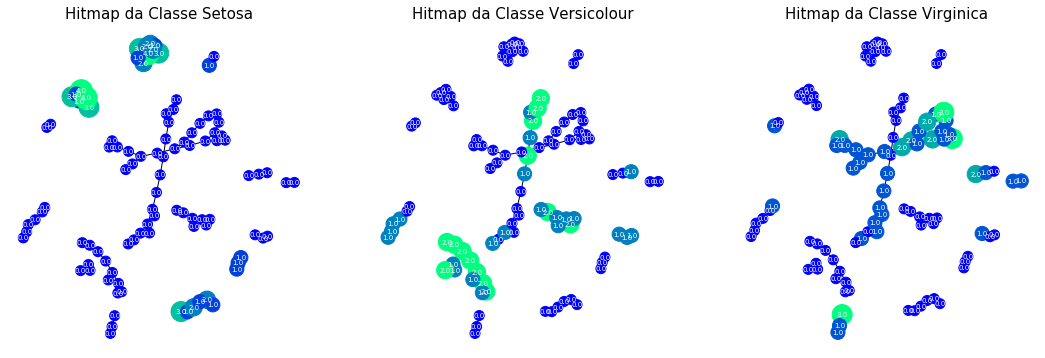

In [18]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
plt.title('Hitmap da Classe Setosa',      fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), iris_X[iris_Y==0]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(142)
plt.title('Hitmap da Classe Versicolour', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), iris_X[iris_Y==1]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(143)
plt.title('Hitmap da Classe Virginica', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), iris_X[iris_Y==2]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

Abaixo e mostrada adaptação da u-matrix implementada (que nesse caso é um grafo) para o dataset iris. Nela pode ser observado a distância dos pesos de um neurônio e seus vizinhos.

Pode ser observado que a maioria dos neurônios está próximo de seus vizinhos, com poucas excessões, fato que também pode ter sido acasionado devido a grande quantidade de neurônios. 

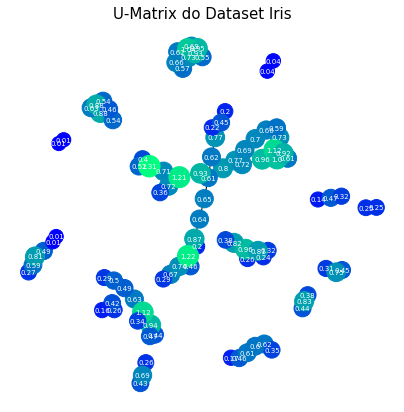

In [19]:
plt.figure(figsize=(7, 7))
plt.title('U-Matrix do Dataset Iris',      fontsize=15)
um = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph)) 
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=200, multiplier=200, font_size=7, color_map = 'winter')

### Dataset 2:  breast cancer wisconsin dataset

In [22]:
def loadBCWD():
    BCWD = load_breast_cancer()
    return BCWD.data, BCWD.target
BCWD_X, BCWD_Y = loadBCWD()

In [23]:
BCWD_X = Normalize(BCWD_X)

In [ ]:
results = grid_search(parameters, BCWD_X)

In [71]:
BCWD_results =pd.DataFrame.from_dict(results)
export_csv = BCWD_results.to_csv(r'results/GNG/BCWD_grid_search.csv', index = None, header=True)

A tabela a seguir mostra os dez melhores modelos de acordo com o erro de quantização para o breast cancer wisconsin dataset. 

Foi obtido um erro quantitativo e topográfico maior que no dataset Iris o que pode indicar que se trata de um dataset mais desafiador.

Em relação a idade máxima da aresta, iterações para adição de neurônios, e número máximo de neurônios permitidos, foram obtidos resultados similares aos do dataset Iris, obtendo a mesma melhor configuração para a rede.

In [10]:
BCWD_results_table = pd.read_csv('results/GNG/BCWD_grid_search_sample.csv')
BCWD_results_table

,max_edge_age,n_iter_before_neuron_added,max_nodes,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,25,25,100,2.309837,0.031634,0.007059,0.002870
1,25,75,100,2.313912,0.044523,0.010359,0.006471
2,25,50,100,2.320018,0.035149,0.006683,0.010045
3,25,100,100,2.323174,0.039250,0.007095,0.000828
4,50,50,100,2.385716,0.022261,0.009113,0.007364
5,50,100,100,2.392604,0.024019,0.009432,0.002192
6,50,75,100,2.396287,0.018161,0.005280,0.000828
7,50,25,100,2.405775,0.023433,0.002533,0.008160
8,75,25,100,2.424233,0.017575,0.007091,0.002485
9,75,75,100,2.429177,0.018161,0.011539,0.000828


O modelo com os seguintes hiperparâmetros foi definido como o melhor por obter o menor erro quantitativo.

In [11]:
BCWD_results_table.loc[[0]]

,max_edge_age,n_iter_before_neuron_added,max_nodes,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,25,25,100,2.309837,0.031634,0.007059,0.00287


A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo.

In [24]:
neural_gas = GrowingNeuralGas(n_inputs=len(BCWD_X[0]),
                              shuffle_data=True,
                              max_edge_age=25,
                              n_iter_before_neuron_added=25,
                              max_nodes=100)
neural_gas.fit( BCWD_X, 100 )

GrowingNeuralGas(verbose=False, step=0.2, show_epoch=1, shuffle_data=True, signals=None, n_inputs=30, n_start_nodes=2, neighbour_step=0.05, max_edge_age=25, max_nodes=100, n_iter_before_neuron_added=25, after_split_error_decay_rate=0.5, error_decay_rate=0.995, min_distance_for_update=0.0)

In [25]:
print('Erro de quantização =', quantization_error(neural_gas.graph, BCWD_X))
print('Erro Topografico =', topographical_error(neural_gas.graph, BCWD_X))
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )

Erro de quantização = 2.2943284870746035
Erro Topografico = 0.043936731107205626


A seguir é apresentado o Heat Map para três exemplos de cada classe, onde pode ser observado que a distância é similar para a maioria dos neurônios, sendo similar para ambas as classes.

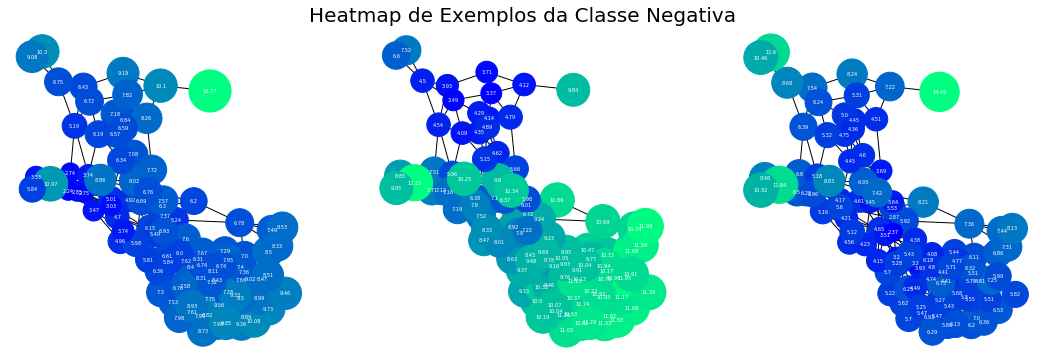

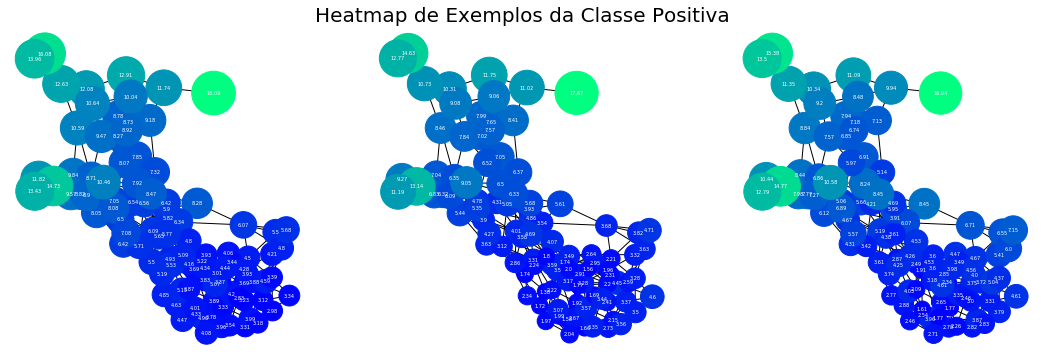

In [26]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[8]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Negativa',      fontsize=20)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[250]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[566]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[37]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe Positiva', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[249]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, BCWD_X[486]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')



O Hit Map mostra que apesar do heat map ser semelhante para as duas classes, exemplos de classes diferentes, em sua grande maioria, estão sendo mapeados para regiões diferentes do mapa. Deve ser observado, no entanto que aparenta haver uma região próxima do centro, onde exemplos de ambas as classes estão sendo mapeadas, o que mostra novamente que esse dataset e mais desafiador.

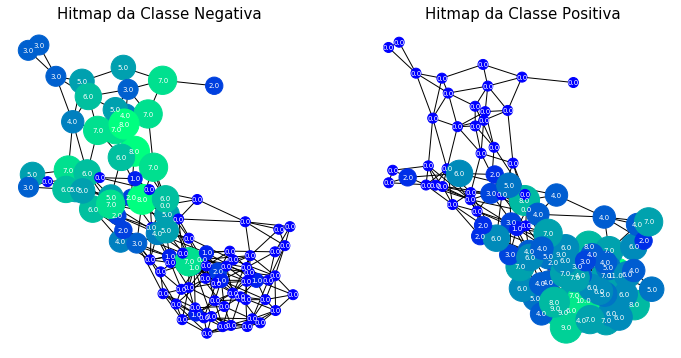

In [27]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
plt.title('Hitmap da Classe Negativa', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), BCWD_X[BCWD_Y==0]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(142)
plt.title('Hitmap da Classe Positiva', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), BCWD_X[BCWD_Y==1]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')


A u-matrix mostra que existem diversos nós próximos de seus vizinhos e um número menor com que está mais distante de seus vizinhos. 

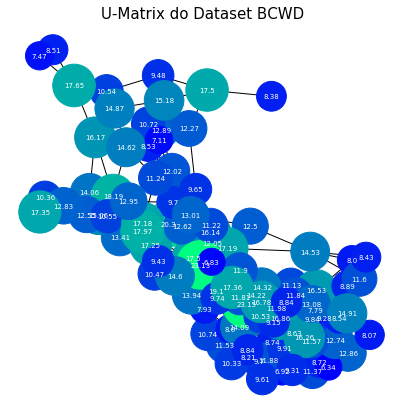

In [29]:
plt.figure(figsize=(7, 7))
plt.title('U-Matrix do Dataset BCWD', fontsize=15)
um = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph)) 
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=50, multiplier=100, font_size=7, color_map = 'winter')

### Dataset 3:  Alcohol QCM Sensor Dataset Data Set

In [80]:
def loadQCM():
    QCM3  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM3.csv', sep=';', header=0)
    QCM3['MIP'] = 1.0
    QCM3['NP']  = 1.0
    QCM6  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM6.csv', sep=';', header=0)
    QCM6['MIP'] = 1.0
    QCM6['NP']  = 0.0
    QCM7  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM7.csv', sep=';', header=0)
    QCM7['MIP'] = 1.0
    QCM7['NP']  = 0.5
    QCM10 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM10.csv', sep=';', header=0)
    QCM10['MIP'] = 1.0
    QCM10['NP']  = 2.0
    QCM12 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM12.csv', sep=';', header=0)
    QCM12['MIP'] = 0.0
    QCM12['NP']  = 1.0
    QCM = pd.concat([QCM3,QCM6,QCM7,QCM10,QCM12], ignore_index=True)
    QCM_X = np.concatenate( [np.array(QCM)[:,0:10], np.array(QCM)[:,15:17]], axis=1)
    QCM_Y_OneHot = np.array(QCM)[:,10:15]
    
    QCM_Y = np.zeros(len(QCM_Y_OneHot))
    for i in range(len(QCM_Y_OneHot)):
        for j in range(len(QCM_Y_OneHot[i])):
            if QCM_Y_OneHot[i,j] == 1:
                QCM_Y[i] = j
                break
    
    return QCM_X, QCM_Y
    
QCM_X, QCM_Y = loadQCM()

In [81]:
QCM_X = Normalize(QCM_X)

In [ ]:
results = grid_search(parameters, QCM_X)

In [83]:
QCM_results =pd.DataFrame.from_dict(results)
export_csv = QCM_results.to_csv(r'results/GNG/QCM_grid_search.csv', index = None, header=True)

A tabela abaixo apresenta os 10 melhores resultados de acordo com o erro quantitativo para o  Alcohol QCM Sensor Dataset Data Set.

Foi obtido um erro quantitativo baixo e erro topográfico de 0 para todos os melhores resultados.

Em relação a idade máxima da aresta e número máximo de neurônios permitidos, foram obtidos resultados similares aos dois datasets anteriores, chegando ao mesmo valor ótimo para esses hiperparâmetros.

Já para o número de iterações para adicionar um novo neurônio, para esse dataset, a rede aparenta favorecer valores mais altos, sendo 75 o número de iterações que obteve os melhores resultados.

In [12]:
QCM_results_table = pd.read_csv('results/GNG/QCM_grid_search_sample.csv')
QCM_results_table

,max_edge_age,n_iter_before_neuron_added,max_nodes,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,25,75,100,0.042994,0,0.000588,0
1,25,100,100,0.043304,0,0.000996,0
2,25,50,100,0.043318,0,0.000842,0
3,25,25,100,0.043456,0,0.001424,0
4,50,100,100,0.045210,0,0.002428,0
5,50,75,100,0.045847,0,0.001935,0
6,50,25,100,0.047676,0,0.000315,0
7,50,50,100,0.047981,0,0.000548,0
8,75,100,100,0.050233,0,0.001166,0
9,75,75,100,0.051093,0,0.000938,0


O seguinte modelo foi definido como o mehor por obter o menor erro de quantização.

In [13]:
QCM_results_table.loc[[0]]

,max_edge_age,n_iter_before_neuron_added,max_nodes,quantization_error,topographical_error,quantization_error_std,topographical_error_std
0,25,75,100,0.042994,0,0.000588,0


A seguir é mostrado novamente o erro de quantização e topográfico do melhor modelo, podendo ser observado que foi obtido um resultado baixo em ambos.

In [ ]:
neural_gas = GrowingNeuralGas(n_inputs=len(QCM_X[0]),
                              shuffle_data=True,
                              verbose=True,
                              max_edge_age=25,
                              n_iter_before_neuron_added=75,
                              max_nodes=100)
neural_gas.fit( QCM_X, 100 )

In [87]:
print('Erro de quantização =', quantization_error(neural_gas.graph, QCM_X))
print('Erro Topografico =', topographical_error(neural_gas.graph, QCM_X))
g, pos = generate_graph( adjacency_matrix(decode_edges(neural_gas.graph), neural_gas.graph.n_nodes) )

Erro de quantização = 0.04495251073240867
Erro Topografico = 0.0


A seguir é apresentado o Heat Map para três exemplos de cada classe. Pode ser observado que exemplos de classes diferentes apresentam uma distância baixa para diversos grupos de nós próximos no mapa. Algumas classes aparentam possuir mapas similares, enquanto outras são bem distintas.

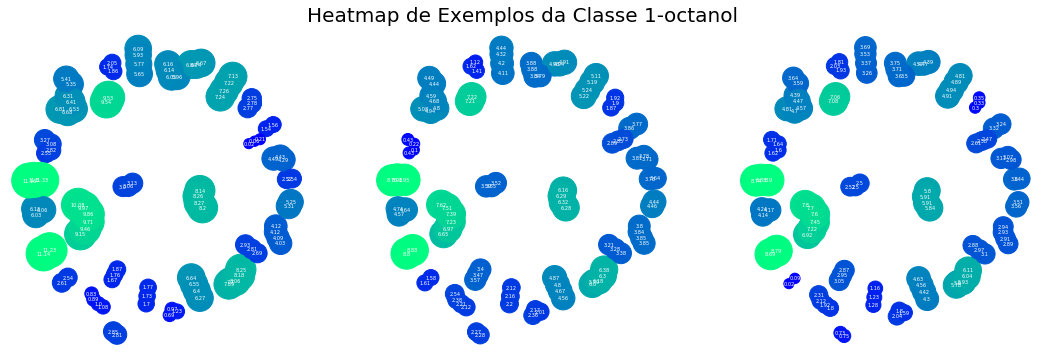

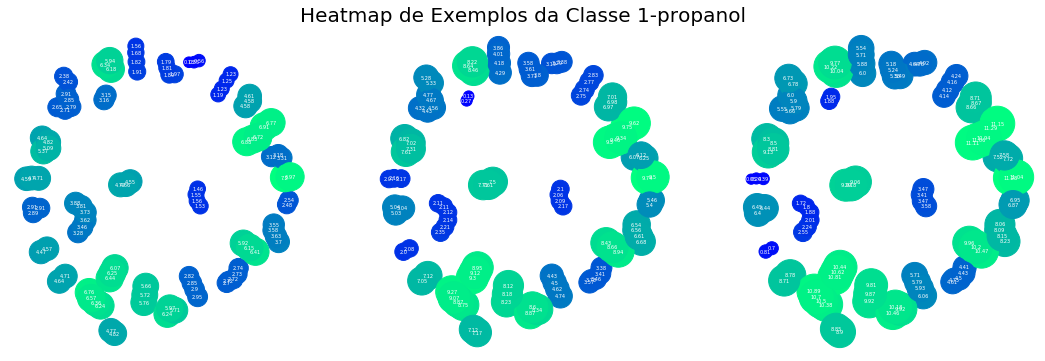

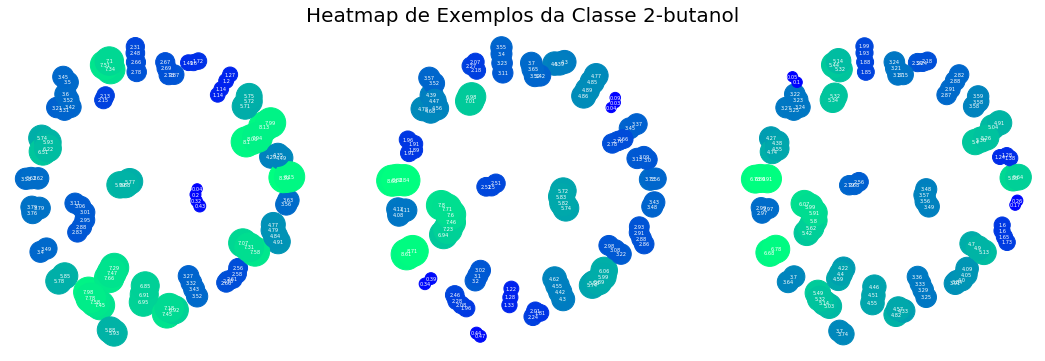

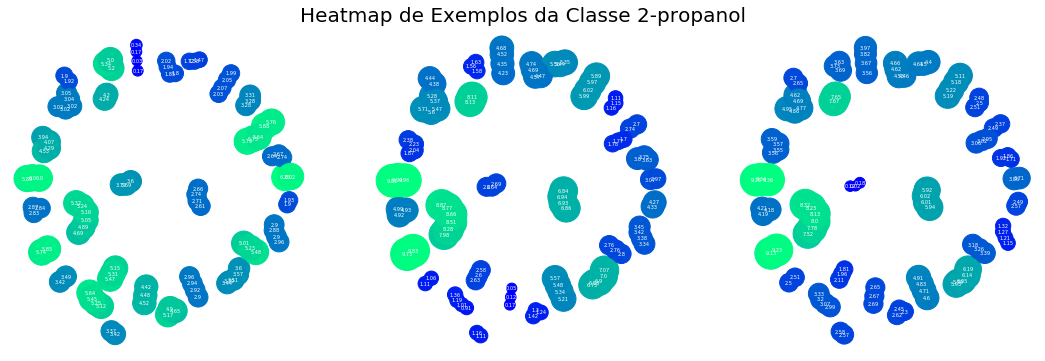

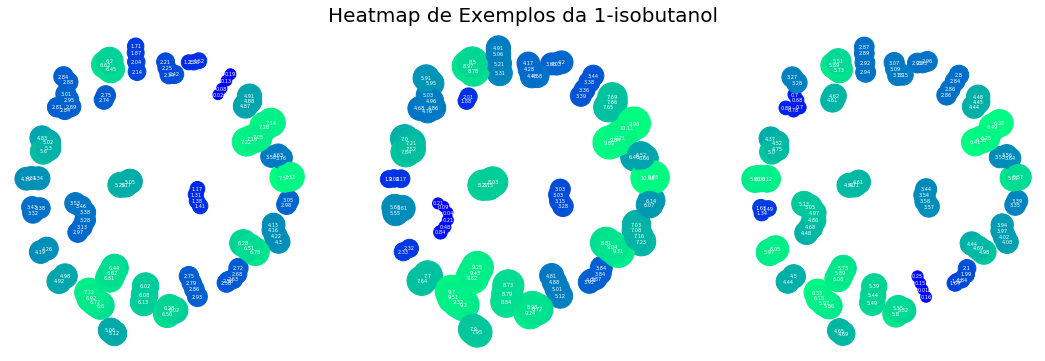

In [88]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[0]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 1-octanol',      fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[28]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[73]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[5]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 1-propanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[30]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[35]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[10]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 2-butanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[62]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[87]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[17]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da Classe 2-propanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[65]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[92]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.show()

plt.figure(figsize=(25, 6))
plt.subplot(141)
hem = heatmap(neural_gas.graph.nodes, QCM_X[24]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(142)
plt.title('Heatmap de Exemplos da 1-isobutanol', fontsize=20)
hem = heatmap(neural_gas.graph.nodes, QCM_X[48]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

plt.subplot(143)
hem = heatmap(neural_gas.graph.nodes, QCM_X[121]) 
print_graph(g, pos, labels=True, values=hem.round(decimals=2), base=100, multiplier=100, font_size=5, color_map = 'winter')

O Hit Map mostra que as classes estão sendo mapeadas para neurônios diferentes no mapa, no entanto, assim como no dataset Iris, é possível observar que há diversos neurônios que não foram escolhidos como BMU por nenhum exemplo no dataset, o que pode ocorrer devido a um excesso de neurônios sendo utilizado e/ou devido a pequena quantidade de exemplos nesse dataset.

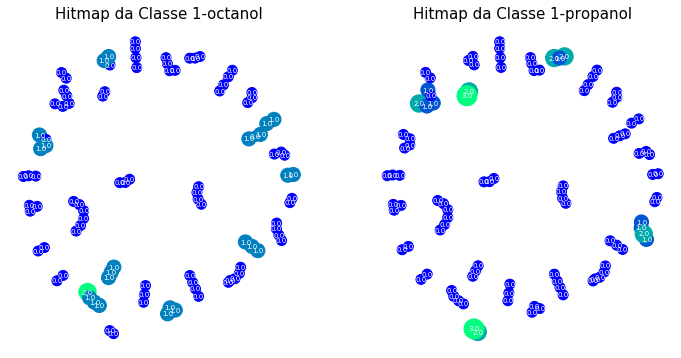

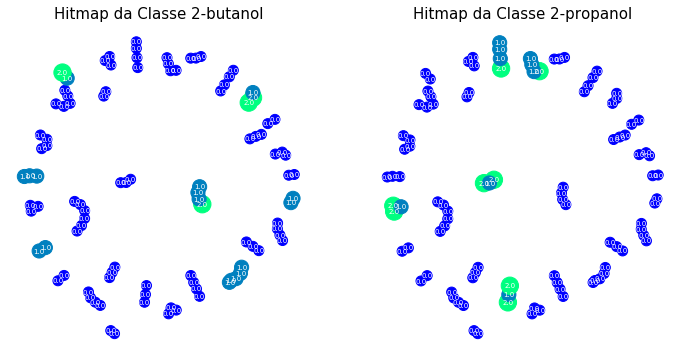

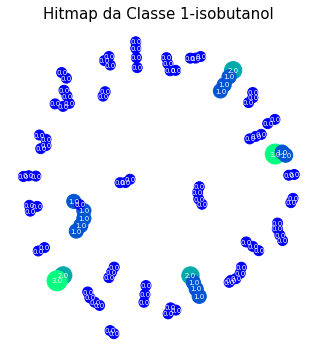

In [92]:
plt.figure(figsize=(25, 6))
plt.subplot(141)
plt.title('Hitmap da Classe 1-octanol',      fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==0]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.subplot(142)
plt.title('Hitmap da Classe 1-propanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==1]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.show()
plt.figure(figsize=(25, 6))

plt.subplot(141)
plt.title('Hitmap da Classe 2-butanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==2]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')


plt.subplot(142)
plt.title('Hitmap da Classe 2-propanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==3]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')

plt.show()
plt.figure(figsize=(25, 6))


plt.subplot(141)
plt.title('Hitmap da Classe 1-isobutanol', fontsize=15)
hm = hitmap(neural_gas.graph.nodes, decode_edges(neural_gas.graph), QCM_X[QCM_Y==4]) 
print_graph(g, pos, labels=True, values=hm.round(decimals=2), base=100, multiplier=100, font_size=7, color_map = 'winter')


A U-Matrix a seguir mostra que nesse dataset, os neurônios conectados um ao outro possuem uma baixa distância entre si.

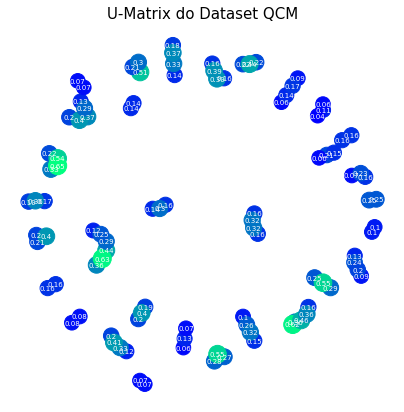

In [93]:
plt.figure(figsize=(7, 7))
plt.title('U-Matrix do Dataset QCM',      fontsize=15)
um = u_matrix(neural_gas.graph.nodes, decode_edges(neural_gas.graph)) 
print_graph(g, pos, labels=True, values=um.round(decimals=2), base=200, multiplier=200, font_size=7, color_map = 'winter')

## Conclusões


De modo geral, pode ser observado que foi possivel obter boas representações para os datasets utilizando a rede GNG. 

Para os dataset Iris e QCM foi observado que poucos neurônios estavam sendo escolhidos como BMU, o que pode indicar que foram utilizados uma quantidade muito grande de neurônios para representar os dados, apesar dos melhores resultados terem sido obtidos com as redes com a maior quantidade de neurônios permitida para todos os datasets.

Para todos os datasets, o menor número de iterações para remover uma aresta foi considerado melhor. Já para o número de iterações necessárias para adicionar um novo exemplo, os datasets Iris e BCWD deram preferência para o valor mais baixo testado, enquanto o dataset QCM obteve seu melhor resultado com o segundo valor mais alto.

O dataset BCWD obteve resultados de erro de quantização mais alto e em seu hitmap aparentava ter uma região onde exemplos de classes diferentes estavam sendo mapeados para os mesmo neuronio, mostrando-se um dataset mais desafiador. Para os demais datasets, os exemplos de classes diferentes foram mapeados para neurônios diferentes da rede.